In [23]:
import pandas as pd
import datetime as dt
from datetime import timedelta
from numpy import random
import plotly.express as px


random.seed(100)

show_intermediate_results = True

n_verkoop_order_df = 158 #random.randint(150,400)

In [24]:
dataframes_list = ['klant_df', 'verkoop_order_df', 'product_df', 'werkorder_df', 'machine_df', 'woonplaatsen_df', 'achternamen_df']

In [25]:
def create_dataframes(dataframes_list):
    for df in dataframes_list:
        vars()[df] = pd.DataFrame()

In [26]:
klant_df = pd.DataFrame(random.randint(0,100,size=(25, 4)),  \
                        columns=['klant_id','klant_naam','klant_achternaam','klant_woonplaats'])
klant_df.index.rename('klant_id', inplace=True)


if show_intermediate_results == True:

    print(klant_df.head(10))

          klant_id  klant_naam  klant_achternaam  klant_woonplaats
klant_id                                                          
0                8          24                67                87
1               79          48                10                94
2               52          98                53                66
3               98          14                34                24
4               15          60                58                16
5                9          93                86                 2
6               27           4                31                 1
7               13          83                 4                91
8               59          67                 7                49
9               47          65                61                14


In [27]:
woonplaatsen_df = pd.read_csv('Woonplaatsen_in_Nederland_2018_07042020_210926.csv', sep='";"', skiprows=3)

woonplaatsen_df = woonplaatsen_df[1:]
new_column_names = list(woonplaatsen_df.columns)
new_column_names[0]='Woonplaats'
woonplaatsen_df.columns = new_column_names

woonplaatsen_df['Woonplaats'] = woonplaatsen_df['Woonplaats'].apply(lambda x: str(x).replace('"', '') )

if show_intermediate_results == True:
    
    print(woonplaatsen_df.head(10) )

         Woonplaats  Gemeente|Naam  Gemeente|Code  Provincie|Naam  \
1            Aadorp          Almelo         GM0141     Overijssel   
2        Aagtekerke           Veere         GM0717        Zeeland   
3            Aalden       Coevorden         GM0109        Drenthe   
4          Aalsmeer        Aalsmeer         GM0358  Noord-Holland   
5   Aalsmeerderbrug  Haarlemmermeer         GM0394  Noord-Holland   
6             Aalst      Zaltbommel         GM0297     Gelderland   
7            Aalsum     Dongeradeel         GM0058      Friesland   
8            Aalten          Aalten         GM0197     Gelderland   
9           Ter Aar       Nieuwkoop         GM0569   Zuid-Holland   
10         Ter Aard           Assen         GM0106        Drenthe   

   Provincie|Code   Landsdeel|Naam Landsdeel|Code"  
1            PV23   Oost-Nederland           LD02"  
2            PV29   West-Nederland           LD03"  
3            PV22  Noord-Nederland           LD01"  
4            PV27   West-Ned

/home/maarten/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



In [28]:
# import modules
#import random
import datetime

# create function accepting a single parameter, the year as a four digit number
def get_random_date(year):

    # try to get a date
    try:
        return datetime.datetime.strptime('{} {}'.format(random.randint(1, 366), year), '%j %Y')

    # if the value happens to be in the leap year range, try again
    except ValueError:
        get_random_date(year)

In [29]:
verkoop_order_df = pd.DataFrame(data=(random.randint(0,25, size=(n_verkoop_order_df, 2))), columns=['klant_id','verkoop_order_datum'])
verkoop_order_df.index.rename('verkoop_order_id', inplace=True)
verkoop_order_df['verkoop_order_datum'] = verkoop_order_df['verkoop_order_datum'].apply(lambda x: get_random_date('2019'))

if show_intermediate_results == True:
    print('n_verkoop_order_df : {}\n'.format(n_verkoop_order_df))
    print(verkoop_order_df.head(10))

n_verkoop_order_df : 158

                  klant_id verkoop_order_datum
verkoop_order_id                              
0                       20          2019-10-20
1                       13          2019-06-29
2                       12          2019-02-03
3                        6          2019-12-19
4                       22          2019-12-09
5                       23          2019-09-07
6                       19          2019-05-02
7                        4          2019-03-28
8                        4          2019-08-09
9                       23          2019-05-15


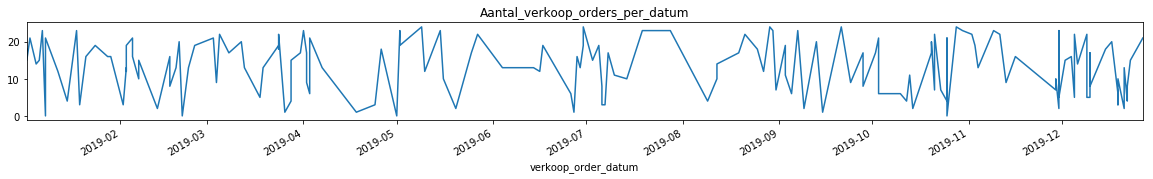

In [30]:
if show_intermediate_results == True:
    verkoop_order_df.plot(x='verkoop_order_datum', figsize=(20,2), legend=False, title='Aantal_verkoop_orders_per_datum', kind='line')

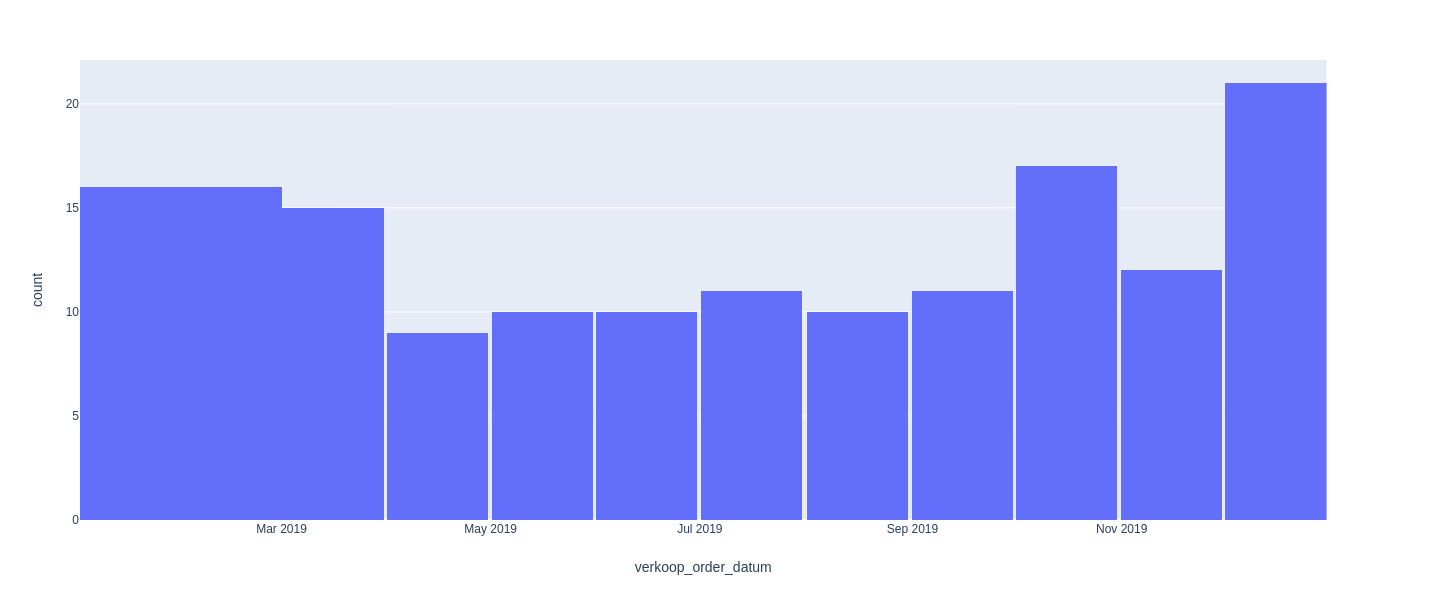

In [76]:
if show_intermediate_results == True:
#    verkoop_order_df.hist(column='klant_id', bins=10)
    fig=px.histogram(verkoop_order_df, x='verkoop_order_datum', nbins=12)
    fig.show()

In [ ]:
if show_intermediate_results == True:
#    verkoop_order_df.hist(column='klant_id', bins=10)
    fig=px.histogram(verkoop_order_df, x='klant_id', nbins=10)
    fig.show()

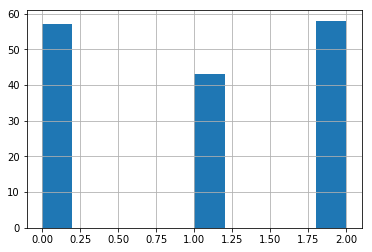

In [32]:
verkoop_order_df['product_id'] = verkoop_order_df['verkoop_order_datum'].apply(lambda x: random.randint(0,3))


if show_intermediate_results == True:
    verkoop_order_df['product_id'].hist()

In [33]:
product_verkoop_prijs_S, product_verkoop_prijs_M, product_verkoop_prijs_L = random.randint(50, 80, size=(3,1))
ratio_kp = 0.6

product_data={
 0:{'name':'Robot arm (S)',
    'kostprijs':product_verkoop_prijs_S,
     'verkoopprijs':product_verkoop_prijs_S*ratio_kp},
 1:{'name':'Robot arm (M)',
    'kostprijs':product_verkoop_prijs_M,
     'verkoopprijs':product_verkoop_prijs_M*ratio_kp},
 2:{'name':'Robot arm (L)',
    'kostprijs':product_verkoop_prijs_L,
     'verkoopprijs':product_verkoop_prijs_L*ratio_kp},
}


product_df = pd.DataFrame.from_dict(product_data, orient='index').reset_index()
product_df.columns = ['product_id','product_naam','product_verkoop_prijs','product_kost_prijs']


product_df.index.rename('product_id', inplace=True)


if show_intermediate_results == True:
    
    print(product_df.head(10) )

            product_id   product_naam product_verkoop_prijs  \
product_id                                                    
0                    0  Robot arm (S)                  [61]   
1                    1  Robot arm (M)                  [72]   
2                    2  Robot arm (L)                  [57]   

              product_kost_prijs  
product_id                        
0                         [36.6]  
1           [43.199999999999996]  
2           [34.199999999999996]  


In [34]:
machine_data ={
    0:{'machine_type':'boor'},
    1:{'machine_type':'frees'},
    2:{'machine_type':'buig'},
    3:{'machine_type':'CNC'},
    4:{'machine_type':'snij'},
    5:{'machine_type':'boor'},
    6:{'machine_type':'stans'},
    7:{'machine_type':'CNC'},
    8:{'machine_type':'snij'},
    9:{'machine_type':'CNC'},
    10:{'machine_type':'CNC'},
    11:{'machine_type':'CNC'},
    12:{'machine_type':'boor'}    
    }
machine_df = pd.DataFrame.from_dict(machine_data, orient='index').reset_index()
machine_df.columns = ['machine_id','machine_type']


machine_df.index.rename('machine_id', inplace=True)


if show_intermediate_results == True:
    
    print(machine_df.head(10) )

            machine_id machine_type
machine_id                         
0                    0         boor
1                    1        frees
2                    2         buig
3                    3          CNC
4                    4         snij
5                    5         boor
6                    6        stans
7                    7          CNC
8                    8         snij
9                    9          CNC


In [35]:
# werkorder_df = pd.DataFrame(data=(random.randint(0,25, size=(n_verkoop_order_df, 2))), columns=['klant_id','verkoop_order_datum'])
werkorder_df = verkoop_order_df.copy()
werkorder_df.reset_index(inplace = True)
werkorder_df.index.rename('werkorder_id', inplace=True)
werkorder_df['werkorder_start_datum'] = werkorder_df['verkoop_order_datum'].apply(lambda x: x+timedelta(days=random.randint(0,2)))
werkorder_df['werkorder_eind_datum'] = werkorder_df['verkoop_order_datum'].apply(lambda x: x+timedelta(days=random.randint(3,10)))


werkorder_df.drop(['klant_id','verkoop_order_datum'], axis=1, inplace=True)

if show_intermediate_results == True:
    print('n_werkorder_df : {}\n'.format(len(werkorder_df)))
    print(werkorder_df.head(10))

n_werkorder_df : 158

              verkoop_order_id  product_id werkorder_start_datum  \
werkorder_id                                                       
0                            0           2            2019-10-20   
1                            1           0            2019-06-30   
2                            2           2            2019-02-04   
3                            3           2            2019-12-19   
4                            4           2            2019-12-09   
5                            5           2            2019-09-08   
6                            6           2            2019-05-02   
7                            7           0            2019-03-28   
8                            8           1            2019-08-10   
9                            9           0            2019-05-15   

             werkorder_eind_datum  
werkorder_id                       
0                      2019-10-29  
1                      2019-07-03  
2                



		Werkorder doorloop tijd



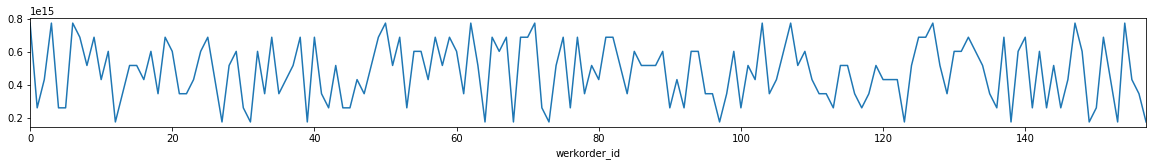

In [52]:
werkorder_df['werkorder_doorlooptijd'] = werkorder_df['werkorder_eind_datum']-werkorder_df['werkorder_start_datum']
werkorder_df['werkorder_maand_nummer'] = werkorder_df['werkorder_eind_datum'].apply(lambda x: x.isocalendar()[2])
werkorder_df['werkorder_doorlooptijd'].plot(figsize=(20,2))



print('\n\n\t\tWerkorder doorloop tijd\n')
#werkorder_df.drop(labels=['werkorder_doorlooptijd'], axis=1, inplace=True)

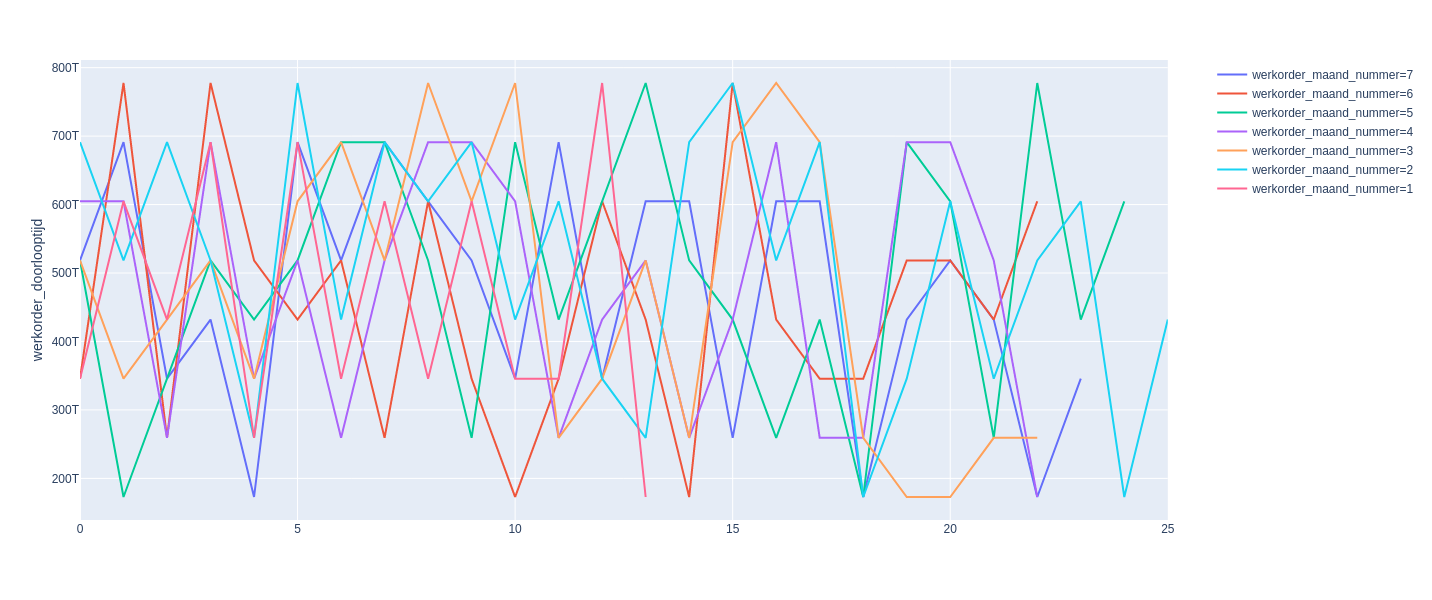

In [61]:
fig = px.line(werkorder_df.sort_values("werkorder_maand_nummer", ascending=False),  y="werkorder_doorlooptijd", color='werkorder_maand_nummer')
fig.show()

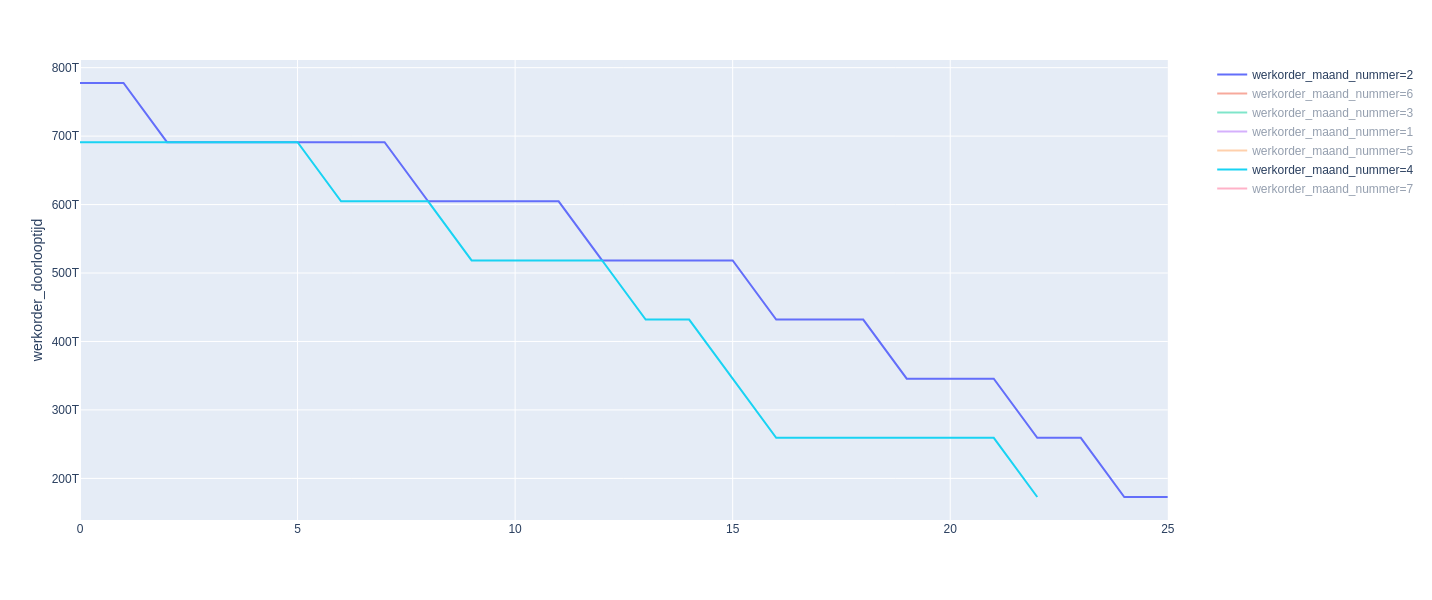

In [59]:
fig = px.line(werkorder_df.sort_values("werkorder_doorlooptijd", ascending=False),  y="werkorder_doorlooptijd", color='werkorder_maand_nummer')
fig.
fig.show()

In [39]:
klant__verkoop_order_df = klant_df.join(verkoop_order_df.set_index('klant_id'), lsuffix='le_', rsuffix='re_')

if show_intermediate_results == True:    
    print(klant__verkoop_order_df.head(8))

          klant_id  klant_naam  klant_achternaam  klant_woonplaats  \
klant_id                                                             
0                8          24                67                87   
0                8          24                67                87   
0                8          24                67                87   
0                8          24                67                87   
1               79          48                10                94   
1               79          48                10                94   
1               79          48                10                94   
1               79          48                10                94   

         verkoop_order_datum  product_id  
klant_id                                  
0                 2019-05-01           2  
0                 2019-02-21           0  
0                 2019-01-08           0  
0                 2019-10-25           2  
1                 2019-04-18           2 

In [40]:
def save_dateframes(dataframes_list):
    
    for df in dataframes_list:
        try:
            globals()[df].to_csv(path_or_buf=str(df)+'.csv', sep='|')
            globals()[df].to_csv(path_or_buf=str(df)+'.tsv', sep='\t')
        except:
            print('Failed to save {} to TSV file.'.format(df))

save_dateframes(dataframes_list)